In [71]:
import numpy as np
import librosa
import os
import glob
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pywt

In [72]:
# Path to your data folder, where heart sound .wav files are stored in class-wise folders
data_path = r"C:\Users\pasar\Desktop\Sem_3\msa\codes\Data"  # Change this to your actual data path

# Example: Dictionary to store extracted features for each heart condition
data = {
    'Mitral Stenosis (MS)': [],  
    'Mitral Regurgitation (MR)': [],  
    'Mitral Valve Prolapse (MVP)': [],  
    'Aortic Stenosis (AS)': [],  
    'Normal': []  
}

In [73]:
def extract_features(file_path):
    # List to store the extracted features
    features = []
    
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # 1. Log Mel Spectrogram
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel_spect = librosa.power_to_db(mel_spect)
    features.append(np.mean(log_mel_spect, axis=1))

    # 2. MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features.append(np.mean(mfccs, axis=1))
    
    # 3. Delta and Delta-Delta (MFCC Derivatives)
    delta_mfcc = librosa.feature.delta(mfccs)
    delta_delta_mfcc = librosa.feature.delta(mfccs, order=2)
    features.append(np.mean(delta_mfcc, axis=1))
    features.append(np.mean(delta_delta_mfcc, axis=1))
    
    # 4. Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec(y, 'db1', level=5)
    features.append(np.hstack([np.mean(c) for c in coeffs]))

    # 5. Chroma Feature
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.append(np.mean(chroma, axis=1))
    
    # 6. Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features.append(np.mean(zcr))
    
    # 7. Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features.append(np.mean(spectral_centroid))
    
    # 8. Spectral Contrast (Dynamically adjusted)
    nyquist = sr / 2  # Nyquist frequency
    fmin = max(200.0, nyquist / 10)  # Ensure fmin is at least 200 Hz or 1/10th of the Nyquist
    n_bands = min(6, int(np.floor(np.log2(nyquist / fmin))))  # Adjust n_bands to not exceed Nyquist
    
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, fmin=fmin, n_bands=n_bands)
    features.append(np.mean(spectral_contrast, axis=1))
    
    # 9. Energy (RMS)
    rms = librosa.feature.rms(y=y)
    features.append(np.mean(rms))
    
    # 10. Temporal Flatness (Spectral Flatness)
    flatness = librosa.feature.spectral_flatness(y=y)
    features.append(np.mean(flatness))
    
    # Combine all features into a single array
    return np.hstack(features)


In [74]:
for label in data.keys():
    folder = os.path.join(data_path, label)
    features_list = []
    for file in glob.glob(folder + "/*.wav"):
        features = extract_features(file)
        if features.size > 0:
            features_list.append(features)
        else:
            print(f"No features extracted for file: {file}")
    data[label] = np.array(features_list)  # Convert to NumPy array

print("Feature extraction completed.")

c:\Users\pasar\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Feature extraction completed.


In [75]:
# Combine all data into one dataset (X) and create labels (y)
X = np.vstack([data['Aortic Stenosis (AS)'], 
               data['Mitral Stenosis (MS)'], 
               data['Mitral Regurgitation (MR)'], 
               data['Mitral Valve Prolapse (MVP)'], 
               data['Normal']])

y = np.concatenate([[0]*len(data['Aortic Stenosis (AS)']),
                    [1]*len(data['Mitral Stenosis (MS)']),
                    [2]*len(data['Mitral Regurgitation (MR)']),
                    [3]*len(data['Mitral Valve Prolapse (MVP)']),
                    [4]*len(data['Normal'])])

print(f"Shape of X (feature matrix): {X.shape}")
print(f"Shape of y (labels): {y.shape}")



Shape of X (feature matrix): (1000, 193)
Shape of y (labels): (1000,)


In [76]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [77]:
from sklearn.model_selection import train_test_split


In [78]:


# Assuming you have X_data (features) and y_labels (labels)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)


In [79]:

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, Input

In [80]:
# Reshape X_train for CNN + LSTM input
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [81]:
def create_cnn_lstm_attention_model(input_shape, num_classes=5):
    inputs = Input(shape=input_shape)
    
    # CNN Layers
    x = layers.Conv2D(64, (3, 1), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, (3, 1), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(128, (3, 1), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 1), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(256, (3, 1), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 1), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 1), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Dropout(0.5)(x)
    
    # Reshape for LSTM
    shape = x.shape
    time_steps = shape[1]
    features = shape[2] * shape[3]
    x = layers.Reshape((time_steps, features))(x)
    
    # LSTM Layer
    x = layers.LSTM(128, return_sequences=True, dropout=0.5)(x)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Fully Connected Layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2], 1)
model = create_cnn_lstm_attention_model(input_shape)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_172"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 193, 1, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 193, 1, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 193, 1, 64)     │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 96, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 96, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 96, 1, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 96, 1, 128)     │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 48, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 48, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 48, 1, 256)     │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 48, 1, 256)     │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 48, 1, 256)     │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 24, 1, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 24, 1, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 24, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_8      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 793,157 (3.03 MB)

 Trainable params: 793,157 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:


history = model.fit(X_train_reshaped, y_train, 
                    validation_data=(X_val_reshaped, y_val),
                    epochs=50, 
                    batch_size=32, 
                    verbose=2)

Epoch 1/50
19/19 - 6s - 298ms/step - accuracy: 0.2200 - loss: 1.6114 - val_accuracy: 0.2400 - val_loss: 1.6086
Epoch 2/50
19/19 - 1s - 54ms/step - accuracy: 0.2717 - loss: 1.5883 - val_accuracy: 0.2900 - val_loss: 1.5924
Epoch 3/50
19/19 - 1s - 54ms/step - accuracy: 0.3200 - loss: 1.5419 - val_accuracy: 0.3250 - val_loss: 1.5394
Epoch 4/50
19/19 - 1s - 55ms/step - accuracy: 0.3850 - loss: 1.4357 - val_accuracy: 0.3900 - val_loss: 1.4249
Epoch 5/50
19/19 - 1s - 65ms/step - accuracy: 0.4250 - loss: 1.3733 - val_accuracy: 0.3500 - val_loss: 1.5257
Epoch 6/50
19/19 - 1s - 63ms/step - accuracy: 0.3950 - loss: 1.4310 - val_accuracy: 0.3450 - val_loss: 1.3581
Epoch 7/50
19/19 - 1s - 62ms/step - accuracy: 0.4550 - loss: 1.2519 - val_accuracy: 0.5150 - val_loss: 1.2301
Epoch 8/50
19/19 - 1s - 58ms/step - accuracy: 0.4833 - loss: 1.1801 - val_accuracy: 0.4200 - val_loss: 1.2561
Epoch 9/50
19/19 - 1s - 60ms/step - accuracy: 0.5267 - loss: 1.1306 - val_accuracy: 0.5250 - val_loss: 1.1525
Epoch 10/

In [83]:
from sklearn.model_selection import KFold
import numpy as np

# Define number of splits for k-fold
num_folds = 5

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store results from each fold
fold_accuracies = []
fold_losses = []

for train_index, val_index in kf.split(X_scaled):
    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Reshape data for CNN + LSTM input
    X_train_fold_reshaped = X_train_fold.reshape(X_train_fold.shape[0], X_train_fold.shape[1], 1)
    X_val_fold_reshaped = X_val_fold.reshape(X_val_fold.shape[0], X_val_fold.shape[1], 1)

    # Create the model for each fold
    model = create_cnn_lstm_attention_model(input_shape)
    
    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the current fold
    history = model.fit(X_train_fold_reshaped, y_train_fold, 
                        validation_data=(X_val_fold_reshaped, y_val_fold),
                        epochs=50, 
                        batch_size=32, 
                        verbose=2)

    # Evaluate the model on the validation set of this fold
    val_loss, val_accuracy = model.evaluate(X_val_fold_reshaped, y_val_fold, verbose=0)
    
    # Store the results
    fold_accuracies.append(val_accuracy)
    fold_losses.append(val_loss)

# Calculate the average accuracy and loss across all folds
average_accuracy = np.mean(fold_accuracies)
average_loss = np.mean(fold_losses)

print(f"Average Accuracy across {num_folds} folds: {average_accuracy:.4f}")
print(f"Average Loss across {num_folds} folds: {average_loss:.4f}")


Epoch 1/50
25/25 - 6s - 223ms/step - accuracy: 0.1963 - loss: 1.6072 - val_accuracy: 0.2700 - val_loss: 1.5954
Epoch 2/50
25/25 - 1s - 55ms/step - accuracy: 0.2188 - loss: 1.5929 - val_accuracy: 0.2600 - val_loss: 1.6031
Epoch 3/50
25/25 - 1s - 52ms/step - accuracy: 0.2512 - loss: 1.5851 - val_accuracy: 0.2750 - val_loss: 1.5553
Epoch 4/50
25/25 - 1s - 52ms/step - accuracy: 0.3187 - loss: 1.5331 - val_accuracy: 0.2600 - val_loss: 1.5029
Epoch 5/50
25/25 - 1s - 51ms/step - accuracy: 0.4225 - loss: 1.3827 - val_accuracy: 0.5400 - val_loss: 1.2848
Epoch 6/50
25/25 - 1s - 51ms/step - accuracy: 0.4487 - loss: 1.3086 - val_accuracy: 0.5200 - val_loss: 1.2720
Epoch 7/50
25/25 - 1s - 53ms/step - accuracy: 0.5275 - loss: 1.2137 - val_accuracy: 0.6150 - val_loss: 1.0562
Epoch 8/50
25/25 - 1s - 57ms/step - accuracy: 0.5425 - loss: 1.1482 - val_accuracy: 0.5800 - val_loss: 1.3037
Epoch 9/50
25/25 - 1s - 51ms/step - accuracy: 0.5587 - loss: 1.0953 - val_accuracy: 0.6650 - val_loss: 0.9711
Epoch 10/

In [84]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


7/7 - 0s - 23ms/step - accuracy: 0.9650 - loss: 0.1257
Test Loss: 0.12567110359668732
Test Accuracy: 0.9649999737739563


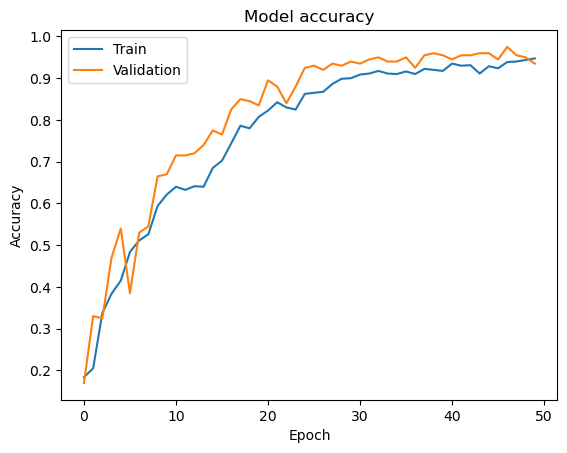

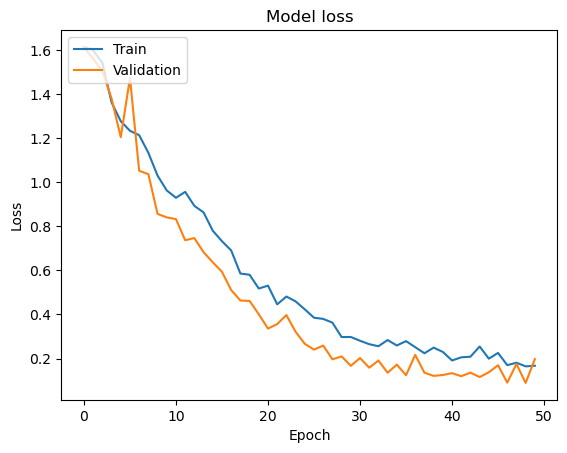

In [85]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [86]:
predictions = model.predict(X_test_reshaped)
predicted_labels = np.argmax(predictions, axis=1)

# Compare with actual labels
print(f"Predicted: {predicted_labels}")
print(f"Actual: {y_test}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Predicted: [4 2 2 0 1 1 0 3 3 2 0 2 3 2 1 1 0 2 4 4 0 4 0 0 2 2 0 0 0 3 0 3 2 0 2 0 4
 3 0 1 0 0 3 1 1 3 4 3 2 4 4 0 4 0 0 0 0 0 1 4 1 1 1 2 1 3 4 3 2 3 0 0 3 1
 4 2 1 4 1 4 3 3 3 0 2 1 0 2 0 1 2 1 2 1 2 2 3 1 1 1 0 2 1 3 2 2 1 4 3 4 4
 0 2 2 2 1 1 3 4 3 3 4 4 4 1 1 1 3 3 0 2 4 4 1 1 1 2 4 4 2 3 0 3 2 1 1 4 4
 3 2 3 3 0 3 4 3 1 0 1 3 3 2 1 1 0 1 0 3 1 4 2 2 1 3 1 1 0 0 0 2 2 4 3 1 4
 3 3 3 1 2 2 4 3 4 3 2 2 1 0 2]
Actual: [4 2 2 0 1 1 0 3 3 2 0 2 3 2 1 1 0 2 4 4 0 4 0 0 2 2 0 0 0 3 0 0 2 0 2 0 4
 0 0 1 0 0 3 1 1 3 4 3 1 4 4 0 4 0 0 0 0 0 1 4 1 1 1 2 1 0 4 3 2 3 0 0 3 1
 4 2 1 4 1 4 3 3 3 0 2 1 0 2 0 1 2 1 2 1 2 2 0 1 1 1 0 2 1 3 2 2 1 1 0 4 4
 0 2 2 2 1 1 3 4 3 3 4 4 4 1 1 1 3 3 0 2 4 4 1 1 1 2 4 4 2 3 0 3 2 1 1 4 4
 3 2 3 3 0 3 4 3 1 0 1 3 3 2 1 1 0 1 0 3 1 4 2 2 1 3 1 1 0 0 0 2 2 4 3 1 4
 3 3 3 1 2 2 4 3 4 3 2 2 1 0 2]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


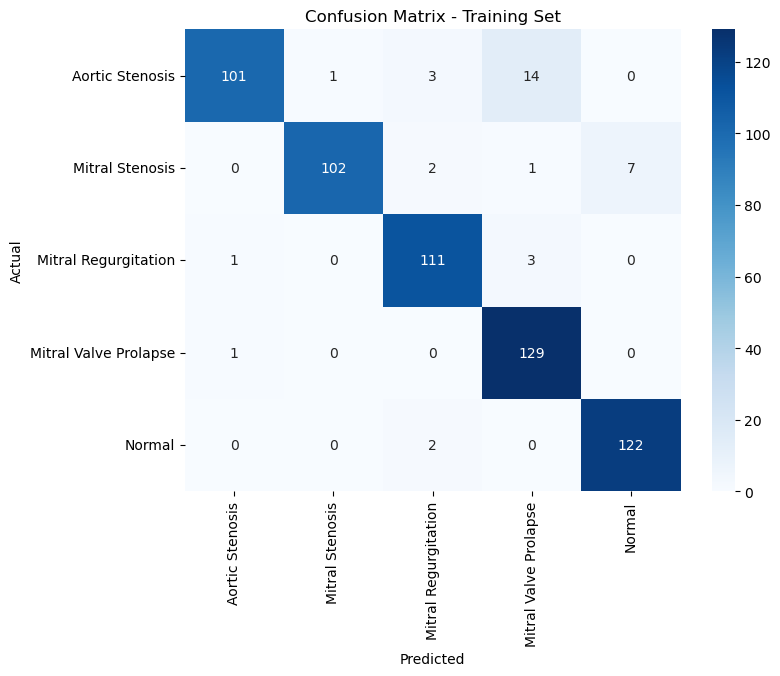

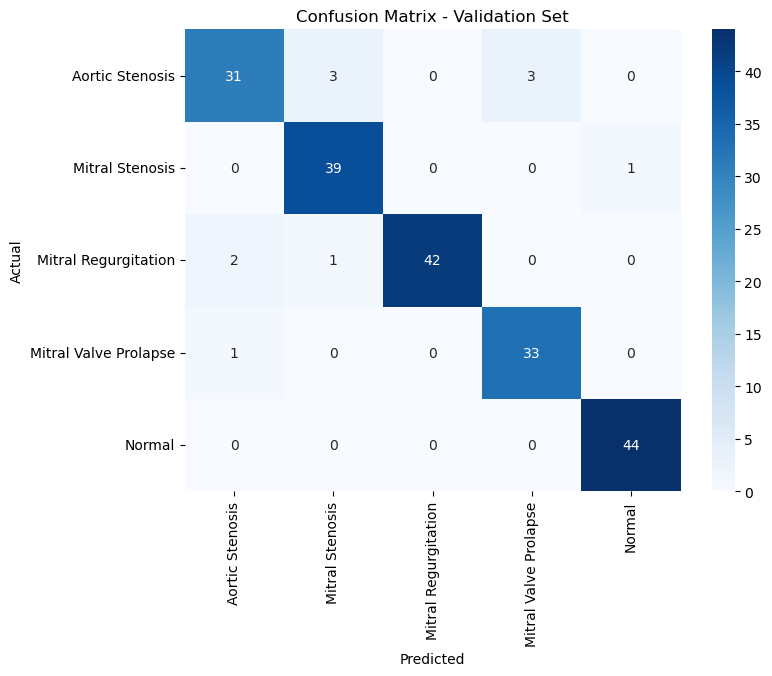

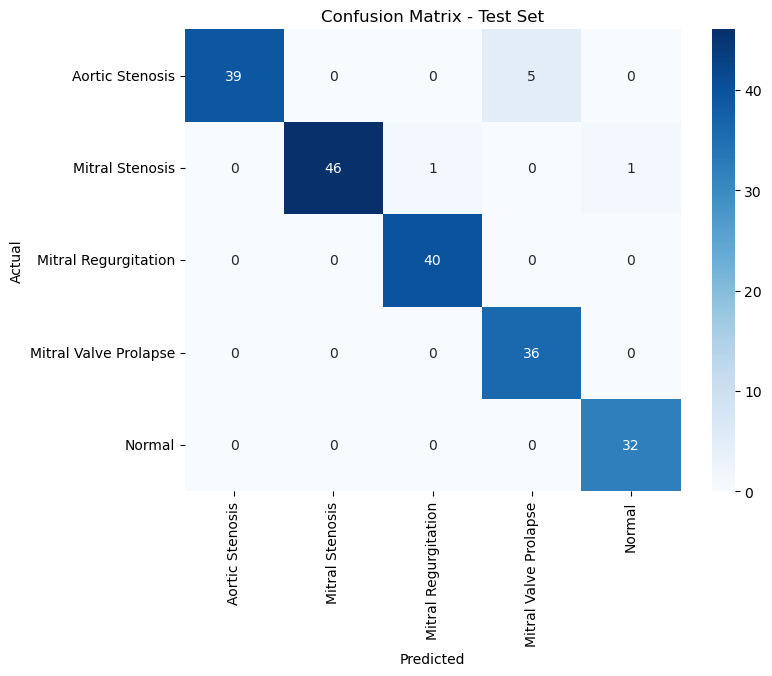

In [87]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, title):
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Get predictions for training, validation, and test data
train_predictions = model.predict(X_train_reshaped)
train_predicted_labels = np.argmax(train_predictions, axis=1)

val_predictions = model.predict(X_val_reshaped)
val_predicted_labels = np.argmax(val_predictions, axis=1)

test_predictions = model.predict(X_test_reshaped)
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Class labels (assuming you have 5 classes: AS, MS, MR, MVP, Normal)
classes = ['Aortic Stenosis', 'Mitral Stenosis', 'Mitral Regurgitation', 'Mitral Valve Prolapse', 'Normal']

# Plot confusion matrix for training data
plot_confusion_matrix(y_train, train_predicted_labels, classes, 'Training Set')

# Plot confusion matrix for validation data
plot_confusion_matrix(y_val, val_predicted_labels, classes, 'Validation Set')

# Plot confusion matrix for test data (optional, if you have a test set)
plot_confusion_matrix(y_test, test_predicted_labels, classes, 'Test Set')


In [92]:
model.save('heartbeat_model.h5')

In [88]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val),
          epochs=50, batch_size=32, callbacks=[tensorboard_callback], verbose=2)


Epoch 1/50
19/19 - 6s - 293ms/step - accuracy: 0.9250 - loss: 0.1950 - val_accuracy: 0.9450 - val_loss: 0.1281
Epoch 2/50
19/19 - 1s - 59ms/step - accuracy: 0.9533 - loss: 0.1466 - val_accuracy: 0.9350 - val_loss: 0.1689
Epoch 3/50
19/19 - 1s - 62ms/step - accuracy: 0.9500 - loss: 0.1307 - val_accuracy: 0.9350 - val_loss: 0.1788
Epoch 4/50
19/19 - 1s - 59ms/step - accuracy: 0.9583 - loss: 0.1172 - val_accuracy: 0.9450 - val_loss: 0.1259
Epoch 5/50
19/19 - 1s - 60ms/step - accuracy: 0.9533 - loss: 0.1214 - val_accuracy: 0.9500 - val_loss: 0.1222
Epoch 6/50
19/19 - 1s - 58ms/step - accuracy: 0.9600 - loss: 0.1274 - val_accuracy: 0.9350 - val_loss: 0.1591
Epoch 7/50
19/19 - 1s - 59ms/step - accuracy: 0.9667 - loss: 0.1044 - val_accuracy: 0.9200 - val_loss: 0.2507
Epoch 8/50
19/19 - 1s - 59ms/step - accuracy: 0.9617 - loss: 0.1234 - val_accuracy: 0.9400 - val_loss: 0.1261
Epoch 9/50
19/19 - 1s - 61ms/step - accuracy: 0.9667 - loss: 0.0984 - val_accuracy: 0.9350 - val_loss: 0.1509
Epoch 10/

In [89]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_model(optimizer='adam', dropout_rate=0.5):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 1), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, (3, 1), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Dropout(dropout_rate)(x)
    # Add more layers as necessary...
    x = layers.Flatten()(x)  # Flatten for the fully connected layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [90]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.3, 0.5, 0.7]
}

best_model = None
best_score = 0

for optimizer in param_grid['optimizer']:
    for dropout_rate in param_grid['dropout_rate']:
        model = create_model(optimizer=optimizer, dropout_rate=dropout_rate)
        history = model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), epochs=10, batch_size=32, verbose=0)
        score = model.evaluate(X_val_reshaped, y_val, verbose=1)[1]
        if score > best_score:
            best_score = score
            best_model = model

print(f"Best score: {best_score}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0333 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9863 - loss: 0.0715 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9724 - loss: 0.1161 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9794 - loss: 0.0584 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9744 - loss: 0.0656 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9518 - loss: 0.1494 
Best score: 0.9900000095367432


In [91]:
best_model.save('best_heart_sound_model.h5')


In [167]:
# Load the new audio file
def load_and_preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    
    # Extract features using the same method as before
    features = extract_features(file_path)
    
    # Standardize the features
    features_scaled = scaler.transform(features.reshape(1, -1))  # Reshape for single sample
    
    # Reshape for model input
    features_reshaped = features_scaled.reshape(features_scaled.shape[0], features_scaled.shape[1], 1)
    
    return features_reshaped

# Specify the path to your unknown WAV file
unknown_file_path = r"C:\Users\pasar\Desktop\Sem_3\msa\Heartbeat\Data_msa_case\Normal_test_case\New_N_199.wav"

# Change this to your actual file path

# Preprocess the audio file
unknown_audio_features = load_and_preprocess_audio(unknown_file_path)

# Make predictions
predictions = best_model.predict(unknown_audio_features)
predicted_class = np.argmax(predictions, axis=1)

# Map the predicted class to its label
class_labels = ['Aortic Stenosis (AS)', 'Mitral Stenosis (MS)', 'Mitral Regurgitation (MR)', 
                'Mitral Valve Prolapse (MVP)', 'Normal']
predicted_label = class_labels[predicted_class[0]]

print(f"The predicted class for the unknown audio file is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
The predicted class for the unknown audio file is: Normal
